<center> <b> <font size="6"> <font color="green">rfBORG </font> - Resistance is futile!  ASSIMILATE OR PERSIH  </font> </b> </center> 

In [1]:
import os
from pynq import Overlay
from pynq import Xlnk
import xrfclk
import xrfdc
import struct
from time import sleep
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# FIRMWARE UPLOAD
firmware = Overlay('bram_lutwave_v4_4.bit')

In [3]:
# INITIALIZING LMK04208 CLOCK
print(xrfclk.get_freq_list())
clksrc = 409.6 # MHz
xrfclk.set_all_ref_clks(clksrc)

dict_keys([102.4, 204.8, 409.6, 737])


In [4]:
#IP INSTANTIATION 
mux = firmware.dac.dac_control_logic.AXI_mux_0 # When 1 pass counter, when 0 pass bram address
bram = firmware.dac.dac_control_logic.bram_interface_0
adc_mem_control = firmware.adc.adc_mem_control_logic.ryans_MMIO_interface_0
amc = firmware.adc.adc_mem_control_logic1.ryans_MMIO_interface_0

In [5]:
#TILE BLOCK CONFIG
dac_tile = firmware.usp_rf_data_converter_0.dac_tiles[1]
dac_block = dac_tile.blocks[2]
adc_tile = firmware.usp_rf_data_converter_0.adc_tiles[0]
adc_block = adc_tile.blocks[1]

In [6]:
if False:
    dac_block.NyquistZone = 1
    adc_block.NyquistZone = 1
    #adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
    #dac_block.UpdateEvent(xrfdc.EVENT_MIXER)

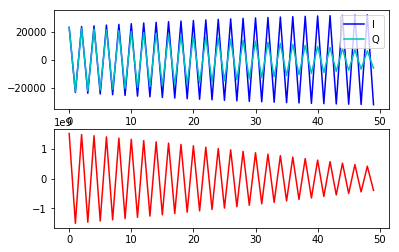

 f_0: 127.500MHz


In [197]:
# Generating DAC Waveform
addr_size=10
data_p = 2**(addr_size+1) # 21 # length of timestream or length of LUT+1
fs = 1024.0e6 # sampling rate of D/A, FPGA fabric = fs/2
C=2 # arb constant
#####################################################
# SET FREQ
#####################################################
freqs = np.linspace(255.0e6,256.0e6,1)*C
A = 2**15-1 # 16 bit D/A, expecting signed values.
freq_res = (fs)/data_p # Hz
#####################################################
# IQ balancing
s1 = 1.0
s2 = 1.0
p = 0.0 #np.pi

################################
# GENERATE WAVEFORM FROM FREQ
################################
freqs = np.round(freqs/(freq_res))*freq_res
delta = np.zeros(data_p,dtype="complex") # empty array of deltas
for i in range(len(freqs)):
    bin_num = np.round((freqs[i]/freq_res)).astype('int')
    delta[bin_num] = 1+1j
ts = np.fft.ifft(delta, norm="ortho")
ts_mod = ts*s1*np.exp(1j*p)
I = (ts.real/max(ts.real)*A).astype("int16") 
#I = (ts.real/max(ts.real)*A).astype("int16") 
Q = (ts_mod.imag/max(ts_mod.imag)*A).astype("int16")

Z = (np.int64(Q)<<16) + I
#Z = (Q << 16) + I
# 'packetizing' data
I_lut = Z.astype("int32") # output
#####################################    

if True: #change to true to see generated timestream
    plt.figure()
    plt.subplot(211)
    plt.plot(I[:50],'b',label="I")
    plt.plot(Q[:50],'c',label="Q")
    plt.legend()
    plt.subplot(212)
    plt.plot(Z[:50],'r')
    plt.show()
for i in range(len(freqs)): print(" f_{:d}: {:.3f}MHz".format(i,freqs[i]*1e-6/(C+2)))

In [198]:
#writing waveform to BRAM
c=0 # control variable
mux.write(0,c) # pass 
bram.write(8,0) # write enable to false
bram.write(12,0) # disnable bram
bram.write(12,1) # enable bram
for i in range(data_p//2):
    if i%100 == 0:
      print("addr: "+str(i) +" val: "+ str(I_lut[i])) 
    bram.write(4,int(I_lut[i])) # write data valueF
    bram.write(0,i) # write address
    bram.write(8,1) # write enable to true save value to address
    bram.write(8,0) # write enable to false to enable reading
mux.write(0,1)
print("DAC CONFIGURED")

addr: 0 val: 1518426753
addr: 100 val: -918064203
addr: 200 val: -2137066635
addr: 300 val: -521763881
addr: 400 val: 1785444580
addr: 500 val: 1724795967
addr: 600 val: -623281540
addr: 700 val: -2144795065
addr: 800 val: -821786176
addr: 900 val: 1591061004
addr: 1000 val: 1893809238
DAC CONFIGURED


In [195]:
# 1 to enable the cyclic read address counter
# c = ~c
# mux.write(0,abs(c))
Mix=True
fc=256.0 # [MHz]

In [196]:
# DAC MIXER SETTINGS in MHz
if Mix:
    # dac_block.MixerSettings
    dac_block.NyquistZone = 1
    adc_block.NyquistZone = 1
    dac_block.MixerSettings = {
        'CoarseMixFreq':  xrfdc.COARSE_MIX_BYPASS,
        'EventSource':    xrfdc.EVNT_SRC_IMMEDIATE,
        'FineMixerScale': xrfdc.MIXER_SCALE_1P0,
        'Freq':           fc,
        'MixerMode':      xrfdc.MIXER_MODE_C2R,
        'MixerType':      xrfdc.MIXER_TYPE_FINE,
        'PhaseOffset':    0.0
        }
    dac_block.UpdateEvent(xrfdc.EVENT_MIXER)
    adc_block.MixerSettings = {
         'CoarseMixFreq':   xrfdc.COARSE_MIX_BYPASS,
         'EventSource':     xrfdc.EVNT_SRC_TILE,
         'FineMixerScale':  xrfdc.MIXER_SCALE_1P0,
         'Freq':            fc,
         'MixerMode':       xrfdc.MIXER_MODE_R2C,
         'MixerType':       xrfdc.MIXER_TYPE_FINE,
         'PhaseOffset':     0.0
        }
    adc_block.UpdateEvent(xrfdc.EVENT_MIXER)
    

## Run Time Process

0. clear reg
1. enb read
2. pulse sclr
3. wait for max count flag
4. disable en_a
5. enable en_b 
6. read from addresses
7. goto 1
  
## Address
- Output
    - SCLR <= slv_reg0(0);  
    - ena <= slv_reg0(1);  
    - enb <= slv_reg0(2);  
    - b_addr <= slv_reg0(16 downto 24);  
- Input
    - max_count <= slv_reg1(0)
    - max_count <= slv_reg1(1)
    - data <=  slv_reg2(31 downto 0)

In [22]:
#write logic
sclr = 2**0
en_a = 2**1
en_b = 2**2
b_addr_lsb = 16-1

#read logic
max_count = 2**0
mem_len = 2**9

In [23]:
adc_mem_control.write(0,0)  
adc_mem_control.write(12,1)
amc.write(0,0)  
amc.write(12,1)

In [25]:
dataI = []
dataQ = []
adc_mem_control.write(12,1)
amc.write(12,1)
if((amc.read(4)&max_count)==1):
    adc_mem_control.write(0, en_a)                            # 1
    amc.write(0, en_a)
    
    adc_mem_control.write(0, en_a | sclr)                     # 2.a
    amc.write(0, en_a | sclr) 
    
    adc_mem_control.write(0, en_a) 
    amc.write(0, en_a) # 2.b
    
    while ((amc.read(4)&max_count) == 0): continue  # 3
    adc_mem_control.write(0,0)
    amc.write(0,0)

    adc_mem_control.write(0, en_b)   
    amc.write(0, en_b)                                               # 5
    for i in range(mem_len):
                                                                     # 6
        adc_mem_control.write(0,en_b | i<<b_addr_lsb)
        amc.write(0,en_b | i<<b_addr_lsb)

        dataI.append(adc_mem_control.read(8))
        dataQ.append(amc.read(8))
    adc_mem_control.write(0,0)  
    amc.write(0,0)                                                   # 0
else:
    print("Run Failed! Counter Running")  
print(sum(dataI))

1108106018836


### LOOPBACK COMPARISON


In [26]:
I_data = np.array(dataI).astype("int32")
Q_data = np.array(dataQ).astype("int32")

In [27]:
data_Ia = (I_data >> 16).astype("int16")
data_Ib = (I_data & 2**(16)-1).astype("int16")
data_Qa = (Q_data >> 16).astype("int16")
data_Qb = (Q_data & 2**(16)-1).astype("int16")

I2 = np.hstack((data_Ib,data_Ia))
Q2 = np.hstack((data_Qb,data_Qa))

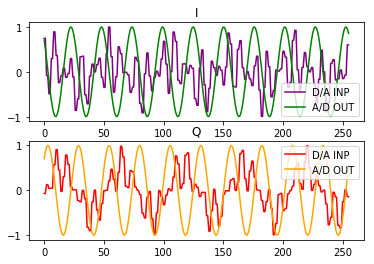

In [28]:
plt.figure()
a=I2/max(I2)
b=Q2/max(Q2)
c=a**2 + b**2
plt.subplot("211")
plt.plot(a[0:256],color="purple",label="D/A INP")
plt.plot(I[0:256]/max(I),color="green",label="A/D OUT")
plt.title("I")
plt.legend()
plt.subplot("212")
plt.title("Q")
plt.plot(b[0:256],color="red",label="D/A INP" )
plt.plot(Q[0:256]/max(Q),color="orange",label="A/D OUT")
plt.legend()
plt.show()

In [74]:
A=np.fft.rfft(a)
B=np.fft.rfft(b)
plt.subplot("221")
Aspec=
Bspec=
plt.plot( (A.real)[0:256] ,color='hotpink')
plt.axvline(10)
plt.subplot("222")
plt.plot(np.fft.fft(I).real[0:256])
plt.subplot("223")
plt.plot((B.real)[0:256],color='hotpink')
plt.subplot("224")
plt.plot(np.fft.fft(Q).real[0:256],"r")
plt.show()

SyntaxError: invalid syntax (<ipython-input-74-7a9ce22978fd>, line 4)

In [69]:
# FREQ TEST
for i in range(len(freqs)): 
    print(" f_{:d} ORGNL: {:.3f}MHz".format(i,freqs[i]*1e-6/(C+2)), end="   ===>\t")
    print(" f_{:d} MIXED: {:.3f}MHz".format(i,freqs[i]*1e-6/(C+2) +dac_block.MixerSettings['Freq']))

 f_0 ORGNL: 10.000MHz   ===>	 f_0 MIXED: 10.000MHz


In [ ]:
adc_block.MixerSettings 

In [ ]:
adc_block.MixerSettings = {
     'CoarseMixFreq': 0,
     'EventSource': 2,
     'FineMixerScale': 0,
     'Freq': 100.0,
     'MixerMode': 3,
     'MixerType': 2,
     'PhaseOffset': 0.0
}

In [ ]:
xrfdc.COARSE_MIX_BYPASS